In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from sklearn.manifold import TSNE

## Traditional VAE

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, latent_dim=2):
        super().__init__()

        #encoder layers
        self.enc_fc1 = nn.Linear(input_dim, hidden_dim)
        self.enc_mu = nn.Linear(hidden_dim, latent_dim)
        self.enc_logvar = nn.Linear(hidden_dim, latent_dim)

        #decoder layers
        self.dec_fc1 = nn.Linear(latent_dim, hidden_dim)
        self.dec_fc2 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = torch.relu(self.enc_fc1(x))
        mu = self.enc_mu(h)
        logvar = self.enc_logvar(h)
        return mu, logvar

    def decode(self, z):
        h = torch.relu(self.dec_fc1(z))
        x_hat = torch.sigmoid(self.dec_fc2(h))
        return x_hat

    def forward(self, x):
        mu, logvar = self.encode(x)
        std = torch.exp(0.5*logvar)
        epsilon = torch.randn_like(std)
        z = mu + epsilon*std
        x_hat = self.decode(z)
        return x_hat, mu, logvar



In [4]:
def loss_function(x, x_hat, mu, logvar):
    recon_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    loss = (recon_loss + kld) / x.size(0)
    return loss

In [5]:
input_dim = 784
hidden_dim = 256
latent_dim = 20
lr = 0.01
batch_size = 256
epochs = 50

train_data = datasets.MNIST(
    root='./data',
    train=True,
    transform=transforms.ToTensor(),
    download=True)

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=batch_size,
    shuffle=True
)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 57.3MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.63MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 12.5MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.81MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
image, label = train_data[1]

In [7]:
image.shape

torch.Size([1, 28, 28])

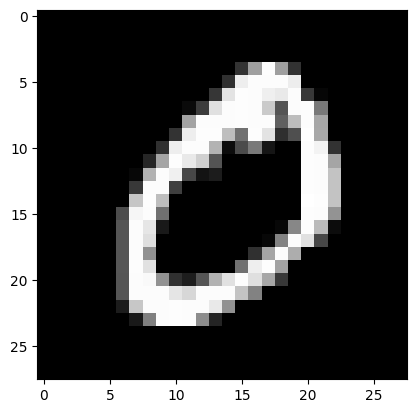

In [8]:
plt.imshow(image.squeeze(), cmap='gray') # squeeze removes the first dimension

In [9]:
vae = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=lr)

Epoch 1, Loss: 0.6586431386311848
Epoch 2, Loss: 0.510145213063558
Epoch 3, Loss: 0.4884172743479411
Epoch 4, Loss: 0.4706134187062581
Epoch 5, Loss: 0.461955064646403
Epoch 6, Loss: 0.4575359925587972
Epoch 7, Loss: 0.45396530621846515
Epoch 8, Loss: 0.45215437571207684
Epoch 9, Loss: 0.4502390284220378
Epoch 10, Loss: 0.44848377901713055
Epoch 11, Loss: 0.4473630223592122
Epoch 12, Loss: 0.4466334049224854
Epoch 13, Loss: 0.44613192494710285
Epoch 14, Loss: 0.4453003171284993
Epoch 15, Loss: 0.44451062355041504
Epoch 16, Loss: 0.44449852078755697
Epoch 17, Loss: 0.44339549153645835
Epoch 18, Loss: 0.44341727549235027
Epoch 19, Loss: 0.44286423517862955
Epoch 20, Loss: 0.4424315138498942
Epoch 21, Loss: 0.44216068471272785
Epoch 22, Loss: 0.44279293696085614
Epoch 23, Loss: 0.4419716059366862
Epoch 24, Loss: 0.4415133730570475
Epoch 25, Loss: 0.4419433073679606
Epoch 26, Loss: 0.4408995010375977
Epoch 27, Loss: 0.4411302235921224
Epoch 28, Loss: 0.4405130663553874
Epoch 29, Loss: 0.44

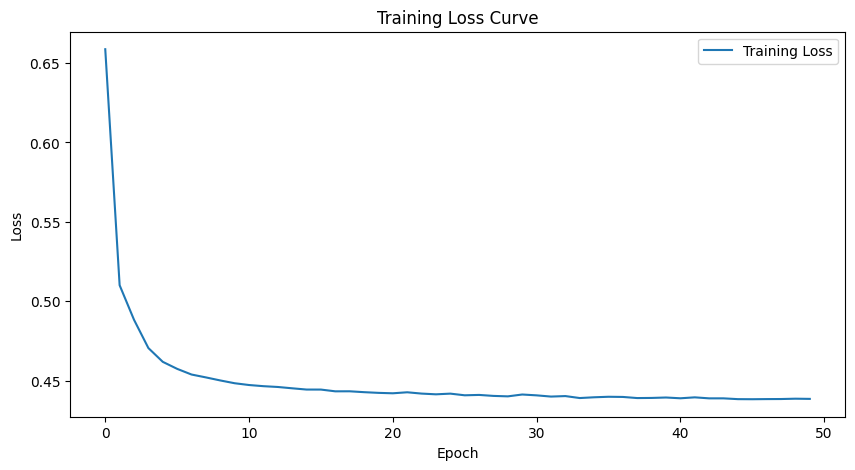

In [10]:
#training

train_losses = []

for epoch in range(epochs):
    train_loss = 0
    for x, _ in train_dataloader:
        x = x.view(-1, 28*28).to(device)
        x_hat, mu, logvar = vae(x)
        loss = loss_function(x, x_hat, mu, logvar)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = train_loss/len(train_dataloader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss}")

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

In [11]:
next(iter(train_dataloader))[0].shape

torch.Size([256, 1, 28, 28])

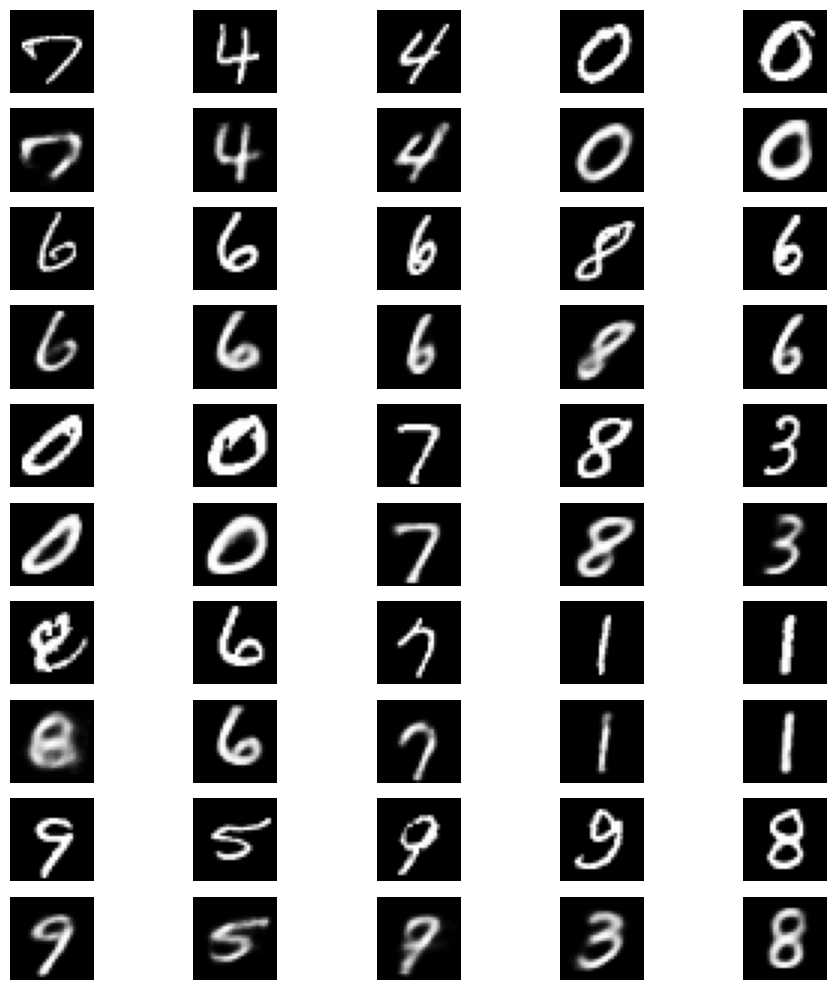

In [12]:
#inference

with torch.no_grad():
    x, _ = next(iter(train_dataloader))
    x = x.view(-1, input_dim).to(device)
    x_hat, _, _ = vae(x)
    x = x.view(-1, 28, 28).cpu()
    x_hat = x_hat.view(-1, 28, 28).cpu()

    num_pairs = 25
    fig, axs = plt.subplots(10, 5, figsize=(10, 10))

    for i in range(num_pairs):
        col = i // 5
        pair_index = i % 5

        original_row = 2 * pair_index
        recon_row = 2 * pair_index + 1

        axs[original_row, col].imshow(x[i].numpy(), cmap='gray')
        axs[recon_row, col].imshow(x_hat[i].numpy(), cmap='gray')

        axs[original_row, col].axis('off')
        axs[recon_row, col].axis('off')

    plt.tight_layout()
    plt.show()

In [14]:
def plot_latent_space(model, data_loader, device):
    model.eval()
    latents = []
    labels = []

    with torch.no_grad():
        for x, y in data_loader:
            x = x.view(-1, 28*28).to(device)
            mu, logvar = model.encode(x)

            latents.append(mu.cpu())
            labels.append(y.cpu())

    latents = torch.cat(latents, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()

    # Perform T-SNE dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42)
    latents_tsne = tsne.fit_transform(latents)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latents_tsne[:, 0], latents_tsne[:, 1], c=labels,
                         cmap='tab10', alpha=0.6)
    plt.colorbar(scatter, ticks=range(10))
    plt.title('T-SNE Visualization of Latent Space')
    plt.xlabel('TSNE 1')
    plt.ylabel('TSNE 2')
    plt.show()



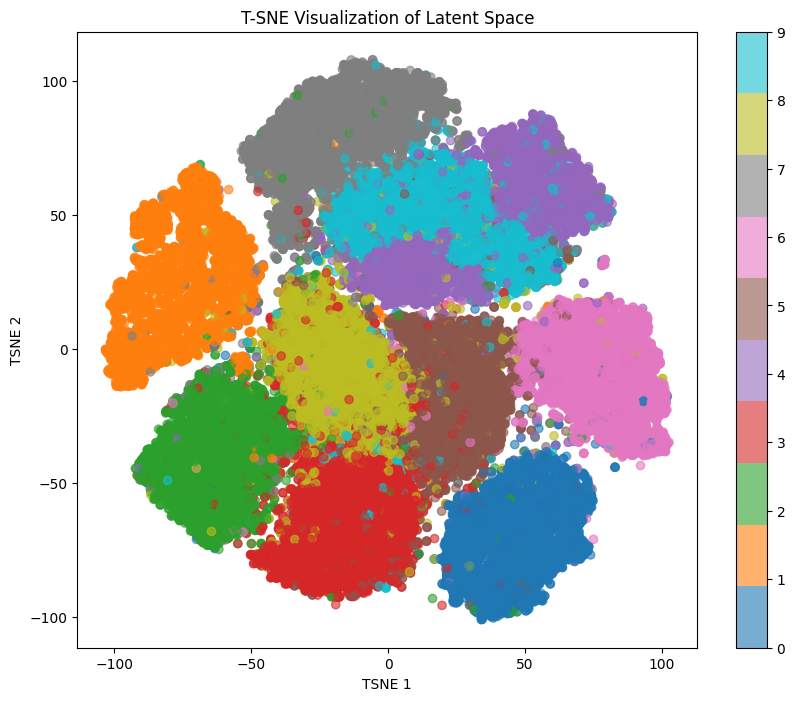

In [15]:
plot_latent_space(vae, train_dataloader, device)

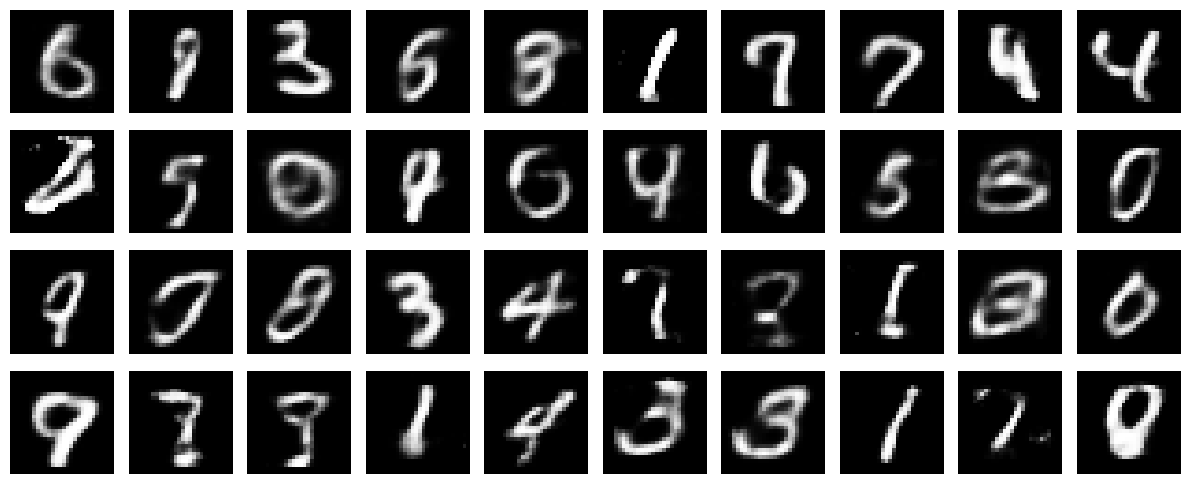

In [17]:
with torch.no_grad():
    z = torch.randn(40, latent_dim)
    sample = vae.decode(z.to(device))
    sample = sample.view(-1, 28, 28).cpu()

    fig, axs = plt.subplots(4, 10, figsize=(12, 5))
    plt.subplots_adjust(wspace=0.05, hspace=0.05)

    for i in range(40):
        row = i // 10
        col = i % 10
        axs[row, col].imshow(sample[i].numpy(), cmap='gray')
        axs[row, col].axis('off')

    plt.tight_layout()
    plt.show()